In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ast

In [2]:
# Read the data
edges_df = pd.read_csv('../Data/edges.csv')
nodes_df = pd.read_csv('../Data/nodes.csv')

In [3]:
# Import nltk for lemmatization
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/dominusdeorum/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/dominusdeorum/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
# Step 1: Get top 1000 artists by popularity
top_artists = nodes_df.nlargest(1000, 'popularity')

# Define the top 10 genres for classification
top_genres = {
    'pop': ['pop', 'k-pop', 'j-pop', 'cantopop', 'mandopop', 'synthpop', 'electropop'],
    'rock': ['rock', 'hard rock', 'punk rock', 'alternative rock', 'indie rock', 'classic rock'],
    'hip-hop': ['hip hop', 'rap', 'trap', 'gangsta rap', 'alternative hip hop'],
    'edm': ['edm', 'electronic', 'house', 'techno', 'dubstep', 'trance'],
    'r&b': ['r&b', 'soul', 'neo soul', 'funk'],
    'country': ['country', 'country pop', 'outlaw country'],
    'jazz': ['jazz', 'bebop', 'swing', 'cool jazz', 'fusion'],
    'classical': ['classical', 'orchestral', 'chamber music', 'baroque', 'romantic', 'symphony'],
    'latin': ['latin', 'reggaeton', 'salsa', 'bachata', 'latin pop'],
    'reggae': ['reggae', 'dub', 'dancehall']
}

# Step 2: Function to map genres to the top genres list
def map_to_top_genres(genre_str):
    if isinstance(genre_str, str):
        # Convert string to list format
        genre_list = [g.strip().strip("'") for g in genre_str.strip('[]').split(',')]
    elif isinstance(genre_str, list):
        # Directly assign if already a list
        genre_list = genre_str
    else:
        return []
    
    mapped_genres = set()
    for genre in genre_list:
        for top_genre, subgenres in top_genres.items():
            if any(sub in genre.lower() for sub in subgenres):
                mapped_genres.add(top_genre)
    return list(mapped_genres) if mapped_genres else []

# Apply the genre mapping function to top 1000 artists
top_artists['cleaned_genres'] = top_artists['genres'].apply(map_to_top_genres)
# Remove artists with empty genre lists
top_artists = top_artists[top_artists['cleaned_genres'].apply(len) > 0]

# Step 3: Function to expand 'chart_hits' into a list of dictionaries
def expand_chart_hits(chart_hits_str):
    if pd.isna(chart_hits_str) or chart_hits_str == '[]':
        return []
    
    try:
        chart_hits = ast.literal_eval(chart_hits_str)
        
        expanded = []
        for entry in chart_hits:
            country, hit_number = entry.replace("(", "").replace(")", "").split()
            expanded.append({
                'country_code': country,
                'hit_number': int(hit_number)
            })
        return expanded
    except Exception as e:
        print(f"Error processing chart hits: {e}")
        return []

# Step 4: Expand and aggregate chart hits data
expanded_hits = []
for idx, row in top_artists.iterrows():
    chart_data = expand_chart_hits(row['chart_hits'])
    for hit in chart_data:
        expanded_hits.append({
            'spotify_id': row['spotify_id'],
            'country_code': hit['country_code'],
            'hit_number': hit['hit_number']
        })

# Create a DataFrame for expanded chart hits
expanded_hits_df = pd.DataFrame(expanded_hits)

# Step 5: Aggregate total hits and number of countries for each artist
grouped_hits = expanded_hits_df.groupby('spotify_id').agg(
    total_hits=('hit_number', 'sum'), 
    num_countries=('country_code', 'nunique')
).reset_index()

# Merge aggregated hits data back into top_artists
top_artists = top_artists.merge(grouped_hits, on='spotify_id', how='left')
# Remove any artist with missing values in chart hits
top_artists = top_artists.dropna(subset=['total_hits', 'num_countries'])


# Step 6: Sort by total hits and get top 100 artists
top_artists = top_artists.sort_values(by='popularity', ascending=False)
top_artists = top_artists.head(100)

# Step 7: Remove outliers for numeric columns using 95% confidence interval
numeric_columns = ['followers', 'popularity']
for column in numeric_columns:
    # Calculate Q1, Q3 and IQR
    Q1 = top_artists[column].quantile(0.025)  # 2.5th percentile for 95% CI
    Q3 = top_artists[column].quantile(0.975)  # 97.5th percentile for 95% CI
    IQR = Q3 - Q1
    
    # Define bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter out outliers
    top_artists = top_artists[
        (top_artists[column] >= lower_bound) & 
        (top_artists[column] <= upper_bound)
    ]

# Display final result
print(top_artists[['spotify_id', 'name', 'cleaned_genres', 'total_hits', 'num_countries']].head())

               spotify_id          name            cleaned_genres  total_hits  \
0  4q3ewBCX7sLwd24euuV69X     Bad Bunny  [latin, reggae, hip-hop]      2122.0   
1  3TVXtAsR1Inumwj472S9r4         Drake            [hip-hop, pop]      5005.0   
2  06HL4z0CvFAxyc27GXpf02  Taylor Swift                     [pop]      3104.0   
3  1Xyo4u8uXC1ZmMpatF05PJ    The Weeknd                [r&b, pop]      3714.0   
4  6KImCVD70vtIoJWnq6nGn3  Harry Styles                     [pop]      1487.0   

   num_countries  
0           71.0  
1           71.0  
2           70.0  
3           71.0  
4           71.0  


# Radar Plot

In [5]:
# Get top 100 artists by popularity
top_100_artists = top_artists.nlargest(100, 'popularity')

# Get all genres from cleaned_genres column and flatten the list for top 100 artists
all_genres = [genre for genres in top_100_artists['cleaned_genres'] for genre in genres]

# Count frequency of each genre
genre_counts = pd.Series(all_genres).value_counts()

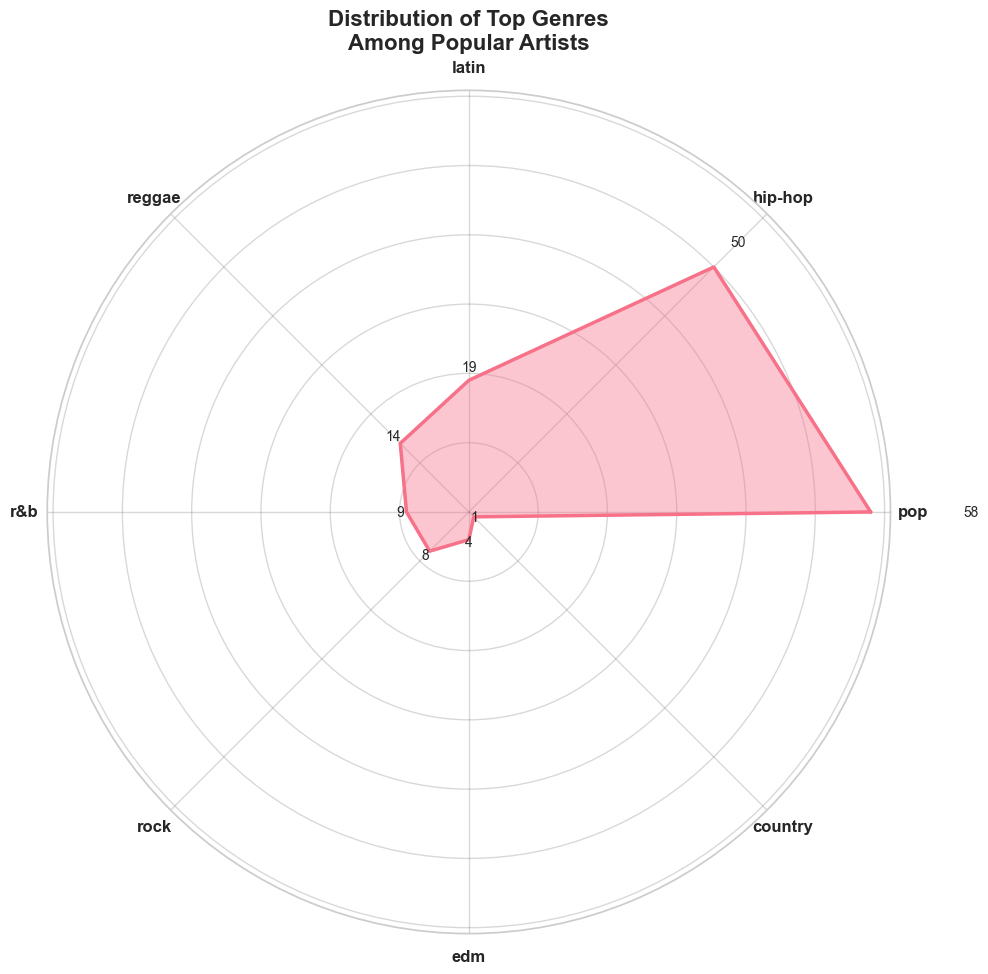


Top Genre Counts:
pop                 :    58
hip-hop             :    50
latin               :    19
reggae              :    14
r&b                 :     9
rock                :     8
edm                 :     4
country             :     1


In [6]:
# Prepare data for radar plot
angles = np.linspace(0, 2*np.pi, len(genre_counts), endpoint=False)
values = genre_counts.values
values = np.concatenate((values, [values[0]]))  # Repeat first value to close the polygon
angles = np.concatenate((angles, [angles[0]]))  # Repeat first angle to close the polygon

# Create DataFrame for seaborn
radar_df = pd.DataFrame({
    'angle': angles[:-1],
    'value': values[:-1],
    'genre': genre_counts.index
})

# Set style for presentation
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)

# Create figure with polar projection
fig = plt.figure(figsize=(10, 10), facecolor='white')  # Increased figure size
ax = fig.add_subplot(111, projection='polar')

# Create radar plot using seaborn's color palette
colors = sns.color_palette("husl", n_colors=1)
ax.plot(angles, values, linewidth=2.5, color=colors[0])
ax.fill(angles, values, alpha=0.4, color=colors[0])

# Customize grid and labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(genre_counts.index, size=12, fontweight='bold')
ax.grid(True, color='gray', alpha=0.3)

# Add value labels at each point with adjusted position
for angle, value, label in zip(angles[:-1], values[:-1], genre_counts.index):
    # Adjust label position based on angle to avoid overlap
    if angle == 0:  # For 'pop' label
        label_radius = value * 1.25  # Push it further out
    else:
        label_radius = value * 1.1
        
    ax.text(angle, label_radius, f'{int(value)}', 
            ha='center', va='center', fontsize=10)

# Customize title with seaborn style
plt.title('Distribution of Top Genres\nAmong Popular Artists', 
          pad=30, size=16, fontweight='bold')

# Remove radial labels and adjust layout
ax.set_yticklabels([])
plt.tight_layout()
plt.show()

# Display genre counts in a formatted way
print("\nTop Genre Counts:")
for genre, count in genre_counts.head(10).items():
    print(f"{genre:<20}: {count:>5}")


In [7]:
# Get top 100 artists by popularity
top_100 = top_artists.nlargest(100, 'popularity')

# Find artists with jazz in their genres among top 100
jazz_artists = top_100[top_100['cleaned_genres'].apply(lambda x: 'country' in x)]

# Display jazz artists sorted by popularity
print("\nJazz Artists in Top 100 (sorted by popularity):")
print(jazz_artists[['name', 'popularity', 'followers', 'cleaned_genres']].sort_values('popularity', ascending=False))

# Print total count
print(f"\nTotal number of jazz artists in top 100: {len(jazz_artists)}")



Jazz Artists in Top 100 (sorted by popularity):
             name  popularity  followers cleaned_genres
73  Morgan Wallen          84  3980170.0      [country]

Total number of jazz artists in top 100: 1


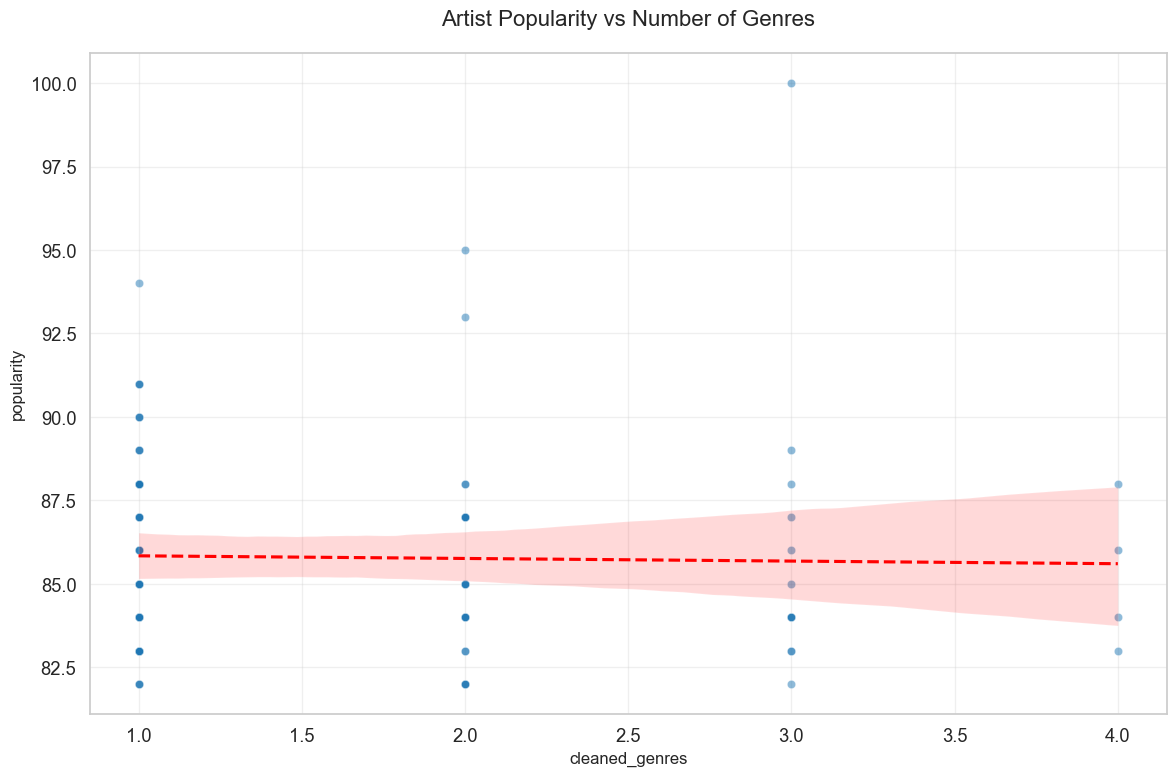


Correlation coefficient between number of genres and popularity: -0.022


In [8]:
# Calculate number of genres per artist
genre_counts_per_artist = top_artists['genres'].apply(lambda x: len(eval(x)))
genre_counts_per_artist = top_artists['cleaned_genres'].apply(lambda x: len(x))

# Create scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(x=genre_counts_per_artist, y=top_artists['popularity'], alpha=0.5)

# Customize plot
plt.title('Artist Popularity vs Number of Genres', size=16, pad=20)
plt.xlabel('Number of Genres', size=12)
plt.ylabel('Popularity Score', size=12)

# Add trend line
sns.regplot(x=genre_counts_per_artist, y=top_artists['popularity'], 
            scatter=False, color='red', line_kws={'linestyle': '--'})

# Add grid and adjust layout
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate correlation coefficient
correlation = genre_counts_per_artist.corr(top_artists['popularity'])
print(f"\nCorrelation coefficient between number of genres and popularity: {correlation:.3f}")


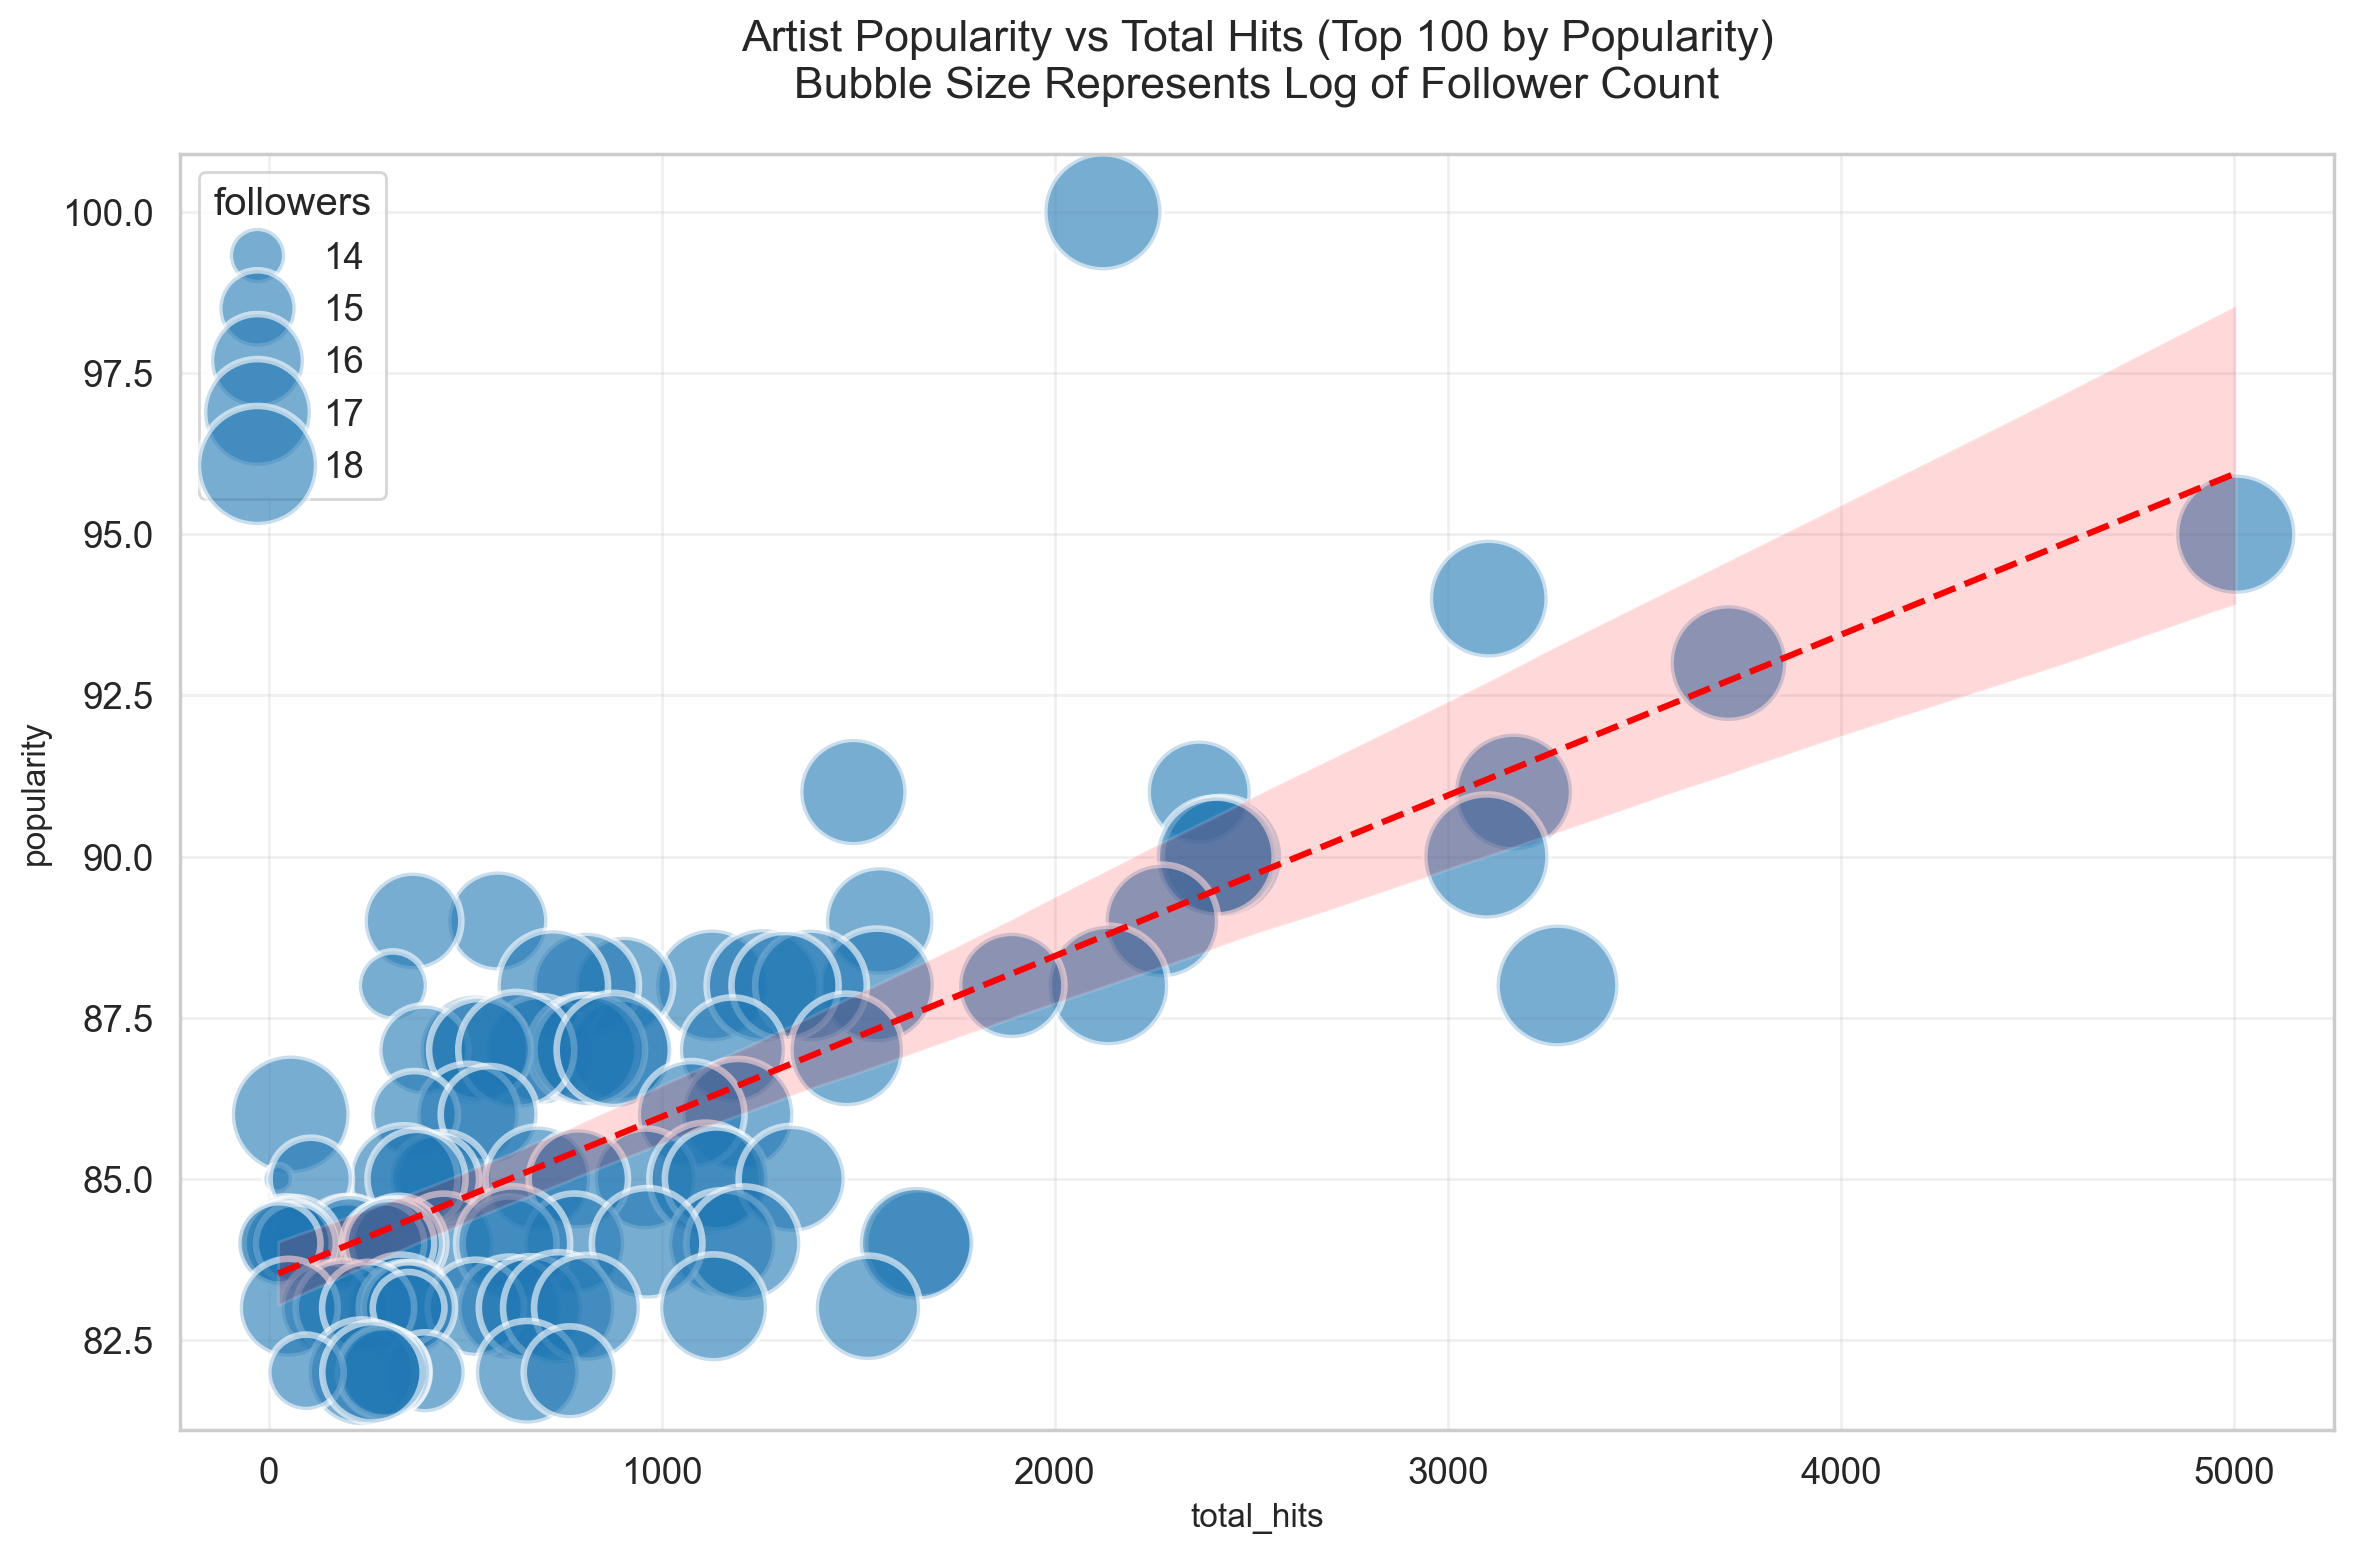


Correlation coefficient between total hits and popularity (Top 100 by Popularity): 0.722


In [9]:
# Get top 100 artists by popularity
top_100 = top_artists.nlargest(100, 'popularity')

# Create bubble chart comparing hits, popularity and followers for top 100 artists
plt.figure(figsize=(12, 8), dpi=200)

# Create bubble plot using log of followers for size
sns.scatterplot(data=top_100, 
                x='total_hits',
                y='popularity',
                size=np.log(top_100['followers']),
                sizes=(100, 2000),  # Adjust bubble size range
                alpha=0.6)

# Customize plot
plt.title('Artist Popularity vs Total Hits (Top 100 by Popularity)\nBubble Size Represents Log of Follower Count', 
         size=16, pad=20)
plt.xlabel('Total Number of Hits', size=12)
plt.ylabel('Popularity Score', size=12)

# Add trend line
sns.regplot(data=top_100,
            x='total_hits',
            y='popularity',
            scatter=False,
            color='red',
            line_kws={'linestyle': '--'})

# Add grid and adjust layout
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate correlation coefficient
correlation = top_100['total_hits'].corr(top_100['popularity'])
print(f"\nCorrelation coefficient between total hits and popularity (Top 100 by Popularity): {correlation:.3f}")


In [10]:
artist_collabs = pd.concat([edges_df['id_0'], edges_df['id_1']]).value_counts().reset_index()
artist_collabs.columns = ['spotify_id', 'collab_count']

top_artists_with_collabs = top_artists.merge(artist_collabs, on='spotify_id', how='left')
top_artists_with_collabs['collab_count'] = top_artists_with_collabs['collab_count'].fillna(0)
top_artists_with_collabs = top_artists_with_collabs[
    (top_artists_with_collabs['collab_count'] >= 
     top_artists_with_collabs['collab_count'].mean() - 2*top_artists_with_collabs['collab_count'].std()) &
    (top_artists_with_collabs['collab_count'] <= 
     top_artists_with_collabs['collab_count'].mean() + 2*top_artists_with_collabs['collab_count'].std())
]
top_artists_with_collabs

,spotify_id,name,followers,popularity,genres,chart_hits,cleaned_genres,total_hits,num_countries,collab_count
0,4q3ewBCX7sLwd24euuV69X,Bad Bunny,55669387.0,100,"['reggaeton', 'trap latino']","['us (76)', 'gb (1)', 'ar (91)', 'au (2)', 'at...","[latin, reggae, hip-hop]",2122.0,71.0,128.0
1,3TVXtAsR1Inumwj472S9r4,Drake,66852536.0,95,"['canadian hip hop', 'canadian pop', 'hip hop'...","['us (190)', 'gb (163)', 'ar (18)', 'au (148)'...","[hip-hop, pop]",5005.0,71.0,111.0
2,06HL4z0CvFAxyc27GXpf02,Taylor Swift,58554324.0,94,['pop'],"['us (136)', 'gb (115)', 'ar (24)', 'au (110)'...",[pop],3104.0,70.0,35.0
3,1Xyo4u8uXC1ZmMpatF05PJ,The Weeknd,49387909.0,93,"['canadian contemporary r&b', 'canadian pop', ...","['us (81)', 'gb (74)', 'ar (23)', 'au (76)', '...","[r&b, pop]",3714.0,71.0,71.0
4,6KImCVD70vtIoJWnq6nGn3,Harry Styles,23284667.0,91,['pop'],"['us (35)', 'gb (35)', 'ar (23)', 'au (35)', '...",[pop],1487.0,71.0,0.0
...,...,...,...,...,...,...,...,...,...,...
95,181bsRPaVXVlUKXrxwZfHK,Megan Thee Stallion,7034241.0,82,"['dance pop', 'houston rap', 'pop', 'rap', 'tr...","['us (26)', 'gb (6)', 'ar (1)', 'au (6)', 'at ...","[hip-hop, pop]",295.0,67.0,68.0
96,6Xgp2XMz1fhVYe7i6yNAax,Trippie Redd,7909088.0,82,"['melodic rap', 'rap', 'trap']","['us (78)', 'gb (7)', 'au (5)', 'at (1)', 'be ...",[hip-hop],291.0,44.0,125.0
97,1DxLCyH42yaHKGK3cl5bvG,Maria Becerra,3091269.0,82,"['latin pop', 'pop argentino']","['ar (21)', 'bo (7)', 'cl (6)', 'co (1)', 'cr ...","[latin, pop]",94.0,17.0,31.0
98,7n2Ycct7Beij7Dj7meI4X0,TWICE,14818846.0,82,"['k-pop', 'k-pop girl group']","['us (1)', 'au (2)', 'bo (1)', 'bg (2)', 'ca (...",[pop],263.0,26.0,7.0


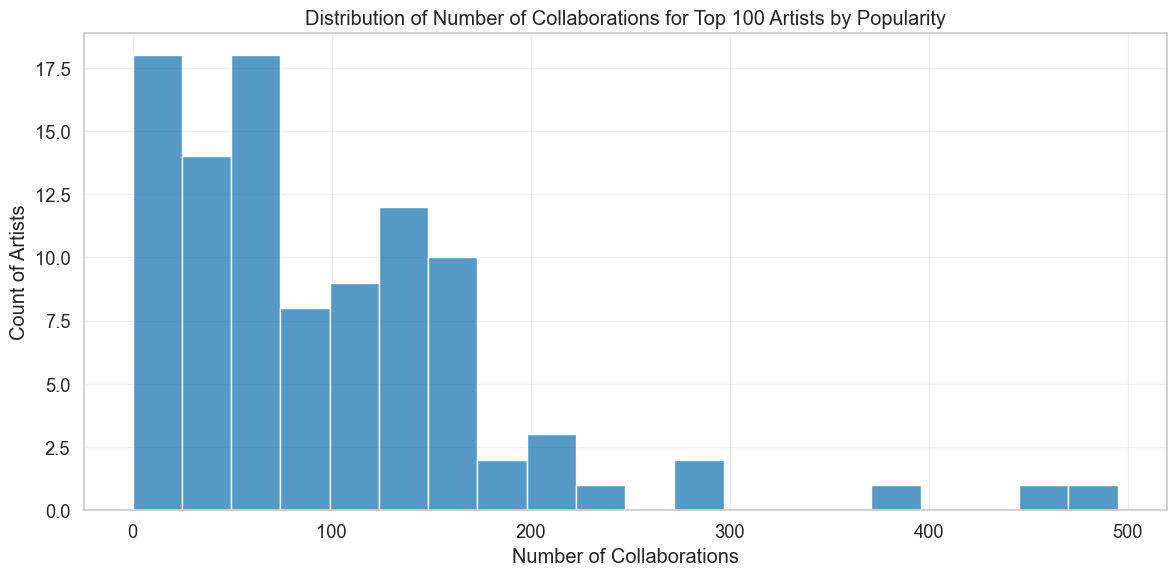


Collaboration Statistics for Top 100 Artists:
Mean collaborations per artist: 98.47
Median collaborations per artist: 76.00
Max collaborations: 495.0
Min collaborations: 0.0

Top 10 artists by number of collaborations (among top 100 by popularity):
             name  collaboration_count
76     Snoop Dogg                495.0
23   David Guetta                452.0
66         Pritam                375.0
60        Farruko                284.0
53      Lil Wayne                273.0
32    Chris Brown                245.0
21         Future                209.0
70     Young Thug                207.0
25       J Balvin                205.0
105     Nicky Jam                194.0


In [11]:
# Get collaboration counts for top 100 artists by popularity
top_100_with_collabs = top_100.copy()
top_100_with_collabs['collaboration_count'] = top_100_with_collabs['spotify_id'].map(artist_collabs.set_index('spotify_id')['collab_count']).fillna(0)

# Create distribution plot
plt.figure(figsize=(12, 6))
sns.histplot(data=top_100_with_collabs['collaboration_count'], bins=20)
plt.title('Distribution of Number of Collaborations for Top 100 Artists by Popularity')
plt.xlabel('Number of Collaborations')
plt.ylabel('Count of Artists')

# Add grid and adjust layout
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nCollaboration Statistics for Top 100 Artists:")
print(f"Mean collaborations per artist: {top_100_with_collabs['collaboration_count'].mean():.2f}")
print(f"Median collaborations per artist: {top_100_with_collabs['collaboration_count'].median():.2f}")
print(f"Max collaborations: {top_100_with_collabs['collaboration_count'].max()}")
print(f"Min collaborations: {top_100_with_collabs['collaboration_count'].min()}")
print(f"\nTop 10 artists by number of collaborations (among top 100 by popularity):")
print(top_100_with_collabs.nlargest(10, 'collaboration_count')[['name', 'collaboration_count']])


In [12]:
# Get artists with minimum collaborations
min_collabs = top_100_with_collabs['collaboration_count'].min()
artists_min_collabs = top_100_with_collabs[top_100_with_collabs['collaboration_count'] <= min_collabs+20]

print(f"\nArtists with minimum collaborations ({min_collabs}):")
print(artists_min_collabs[['name', 'popularity', 'collaboration_count']].to_string(index=False))



Artists with minimum collaborations (0.0):
             name  popularity  collaboration_count
     Harry Styles          91                  0.0
    Billie Eilish          88                 14.0
        BLACKPINK          87                  4.0
   Arctic Monkeys          86                  0.0
          ROSALÍA          86                 14.0
   Olivia Rodrigo          85                  5.0
       Steve Lacy          84                 17.0
    One Direction          84                 13.0
The Neighbourhood          84                 18.0
            Adele          84                  7.0
            Queen          84                 11.0
    Morgan Wallen          84                  9.0
      The Beatles          83                  6.0
      Frank Ocean          83                 10.0
        Metallica          82                 19.0
            TWICE          82                  7.0


Popularity Vs Colaborations 

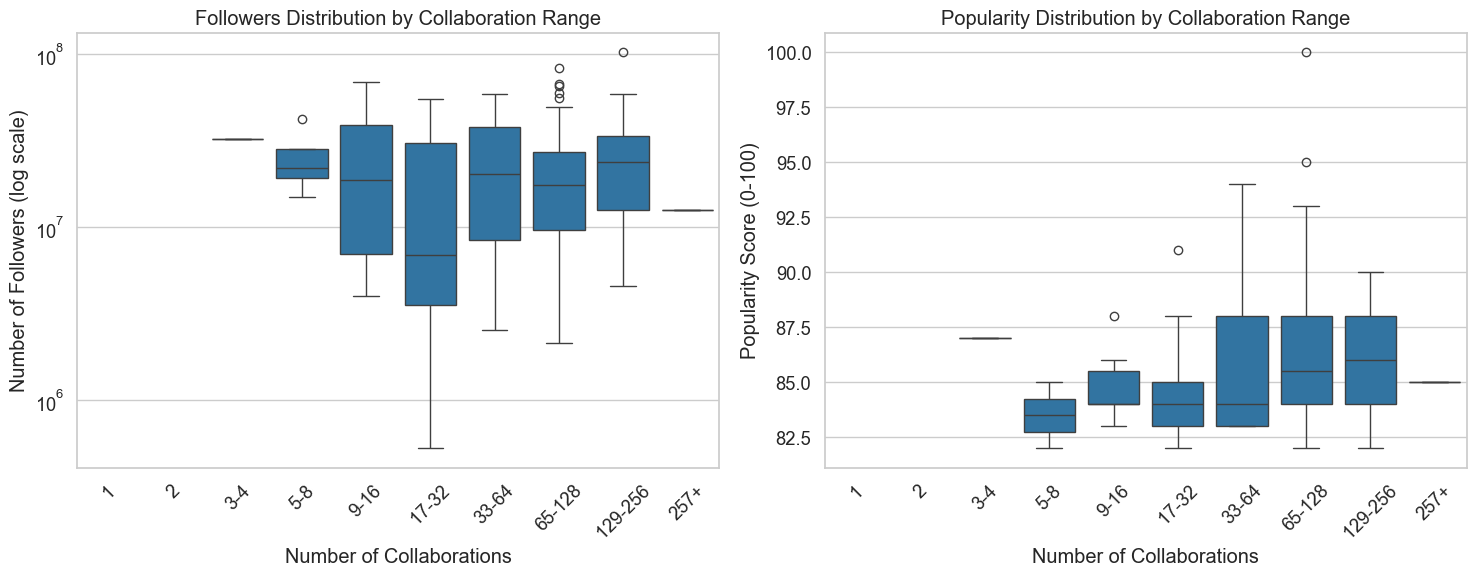

=== Summary Statistics ===

Median values for each collaboration range:

Followers:
collab_range
1                 NaN
2                 NaN
3-4        32382333.0
5-8        22031956.0
9-16       18619386.0
17-32       6831881.0
33-64      20100976.0
65-128     17562451.5
129-256    23715339.0
257+       12587804.0
Name: followers, dtype: float64

Popularity:
collab_range
1           NaN
2           NaN
3-4        87.0
5-8        83.5
9-16       84.0
17-32      84.0
33-64      84.0
65-128     85.5
129-256    86.0
257+       85.0
Name: popularity, dtype: float64


/var/folders/3s/m0cz_jjn4fqfdv71rvtl6bpr0000gn/T/ipykernel_44886/3325289582.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(top_artists_with_collabs.groupby('collab_range')['followers'].median())
/var/folders/3s/m0cz_jjn4fqfdv71rvtl6bpr0000gn/T/ipykernel_44886/3325289582.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(top_artists_with_collabs.groupby('collab_range')['popularity'].median())


In [13]:
# Set up the visualization parameters
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Create collaboration range categories
top_artists_with_collabs['collab_range'] = pd.cut(top_artists_with_collabs['collab_count'], 
                                                 bins=[0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 1800],
                                                 labels=['1', '2', '3-4', '5-8', '9-16', '17-32', 
                                                       '33-64', '65-128', '129-256', '257+'])

# Plot followers boxplot (log scale)
sns.boxplot(data=top_artists_with_collabs, 
           x='collab_range', 
           y='followers',
           ax=ax1)
ax1.set_yscale('log')
ax1.set_title('Followers Distribution by Collaboration Range')
ax1.set_xlabel('Number of Collaborations')
ax1.set_ylabel('Number of Followers (log scale)')
ax1.tick_params(axis='x', rotation=45)

# Plot popularity boxplot
sns.boxplot(data=top_artists_with_collabs, 
           x='collab_range', 
           y='popularity',
           ax=ax2)
ax2.set_title('Popularity Distribution by Collaboration Range')
ax2.set_xlabel('Number of Collaborations')
ax2.set_ylabel('Popularity Score (0-100)')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Print some statistics for each range
print("=== Summary Statistics ===")
print("\nMedian values for each collaboration range:")
print("\nFollowers:")
print(top_artists_with_collabs.groupby('collab_range')['followers'].median())
print("\nPopularity:")
print(top_artists_with_collabs.groupby('collab_range')['popularity'].median())

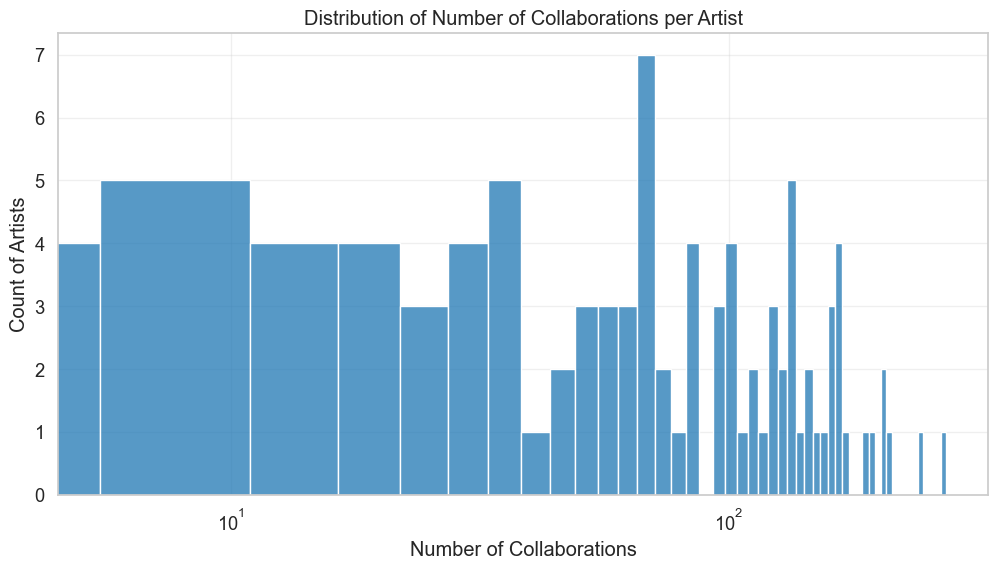


Collaboration Count Summary Statistics:
count     96.000000
mean      85.843750
std       62.199057
min        0.000000
25%       32.750000
50%       70.500000
75%      132.000000
max      273.000000
Name: collab_count, dtype: float64


In [14]:
# Create a histogram of collaboration counts
plt.figure(figsize=(12, 6))
sns.histplot(data=top_artists_with_collabs, x='collab_count', bins=50)
plt.title('Distribution of Number of Collaborations per Artist')
plt.xlabel('Number of Collaborations')
plt.ylabel('Count of Artists')

# Add a log scale to x-axis since the distribution is likely right-skewed
plt.xscale('log')

# Add grid for better readability
plt.grid(True, alpha=0.3)

plt.show()

# Print summary statistics
print("\nCollaboration Count Summary Statistics:")
print(top_artists_with_collabs['collab_count'].describe())


In [15]:
# Create a new dataframe with exploded genres
genre_artist_df = pd.DataFrame({
    'artist_name': top_artists_with_collabs['name'].repeat(top_artists_with_collabs['cleaned_genres'].str.len()),
    'genre': [genre for genres in top_artists_with_collabs['cleaned_genres'] for genre in genres]
})

# Display the first few rows to verify the structure
print("\nFirst few rows of the genre-artist relationship:")
print(genre_artist_df.head(10))

# Print total number of genre-artist relationships
print(f"\nTotal number of genre-artist relationships: {len(genre_artist_df)}")



First few rows of the genre-artist relationship:
    artist_name    genre
0     Bad Bunny    latin
0     Bad Bunny   reggae
0     Bad Bunny  hip-hop
1         Drake  hip-hop
1         Drake      pop
2  Taylor Swift      pop
3    The Weeknd      r&b
3    The Weeknd      pop
4  Harry Styles      pop
5           BTS      pop

Total number of genre-artist relationships: 154


In [16]:
# Get genre counts per artist
genre_counts = genre_artist_df.groupby('artist_name').size().sort_values(ascending=False)

# Get top 3 artists with most genres
print("=== Top 3 Artists with Most Genres ===")
top_3_artists = genre_counts.head(3)
for artist, count in top_3_artists.items():
    genres = genre_artist_df[genre_artist_df['artist_name'] == artist]['genre'].tolist()
    print(f"\n{artist}:")
    print(f"Number of genres: {count}")
    print(f"Genres: {', '.join(genres)}")

# Get bottom 3 artists with least genres
print("\n=== Bottom 3 Artists with Least Genres ===")
bottom_3_artists = genre_counts.tail(3)
for artist, count in bottom_3_artists.items():
    genres = genre_artist_df[genre_artist_df['artist_name'] == artist]['genre'].tolist()
    print(f"\n{artist}:")
    print(f"Number of genres: {count}")
    print(f"Genres: {', '.join(genres)}")


=== Top 3 Artists with Most Genres ===

Feid:
Number of genres: 4
Genres: latin, reggae, hip-hop, pop

Sech:
Number of genres: 4
Genres: latin, reggae, hip-hop, pop

Manuel Turizo:
Number of genres: 4
Genres: latin, reggae, hip-hop, pop

=== Bottom 3 Artists with Least Genres ===

J. Cole:
Number of genres: 1
Genres: hip-hop

Imagine Dragons:
Number of genres: 1
Genres: rock

YoungBoy Never Broke Again:
Number of genres: 1
Genres: hip-hop


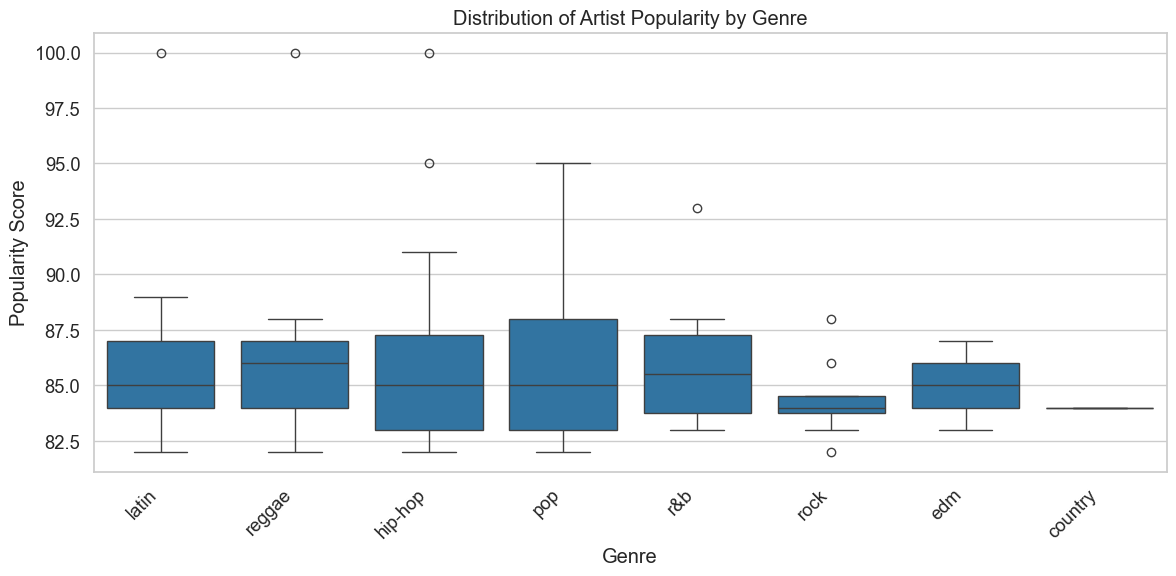


Popularity Statistics by Genre:
         count       mean       std   min    25%   50%    75%    max
genre                                                               
country    1.0  84.000000       NaN  84.0  84.00  84.0  84.00   84.0
edm        3.0  85.000000  2.000000  83.0  84.00  85.0  86.00   87.0
hip-hop   48.0  85.770833  3.471707  82.0  83.00  85.0  87.25  100.0
latin     18.0  86.055556  4.021592  82.0  84.00  85.0  87.00  100.0
pop       55.0  85.836364  3.137371  82.0  83.00  85.0  88.00   95.0
r&b        8.0  86.125000  3.313932  83.0  83.75  85.5  87.25   93.0
reggae    13.0  86.461538  4.483588  82.0  84.00  86.0  87.00  100.0
rock       8.0  84.375000  1.846812  82.0  83.75  84.0  84.50   88.0


In [18]:
# Calculate mean popularity for each genre
genre_popularity = genre_artist_df.merge(
    top_artists_with_collabs[['name', 'popularity']], 
    left_on='artist_name', 
    right_on='name'
)

# Create box plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=genre_popularity, x='genre', y='popularity')
plt.title('Distribution of Artist Popularity by Genre')
plt.xlabel('Genre')
plt.ylabel('Popularity Score')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nPopularity Statistics by Genre:")
print(genre_popularity.groupby('genre')['popularity'].describe())
